## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Perform camera calibration

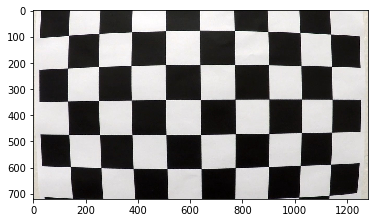

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#display first camera calibration image
img = mpimg.imread('./camera_cal/calibration1.jpg')
plt.imshow(img)

---
The calbration images are read from the camera_cal folder, are transformed to grayscale and the chessboard corners are extracted from each image. If the corners are found correctly (ret == true), their coordinates are appended to the array imgpoints. At the same time the location of the undistorted chessboard corners is appended to the array objpoints. These are the same for each image. Once the data from all images is collected the function calibrateCamera is used to compute the camera matrix mtx (focal length and location of image center) and the distortion coefficients dist for the used camera. These coefficients can then be used to get undistorted camera images. Several images are required during the calibration process to make the optimization more robust.

In [2]:
import glob
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(2000)

# Compute calibration matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

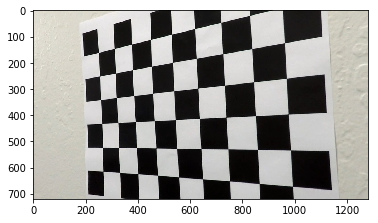

In [3]:
# Apply calibration to test image
img = mpimg.imread('./camera_cal/calibration4.jpg')
img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(img)

## Define image processing class
The image processing class holds all functions that are used to process the images in the later sections of this notebook. These are the following:
- load image: load a new image
- grayscale: convert to grayscale
- gaussian blur: apply gaussian blur filter
- canny: gradient based feature extraction
- hough: fit lines through the features detected with canny; this function includes a kalman filter that can be used to make the fit more robust by using information from previous frames (e.g. from a video).

In [4]:
import math
from numpy.linalg import inv

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

class imgproc:
    def __init__(self,img):
        #image parameters
        self.img = img
        self.orig = img
        self.thresh = np.zeros_like(img)
        self.warped = np.zeros_like(img)
        #camera parameters
        self.mtx = [] #camera matrix (focal length and image center)
        self.dist = [] #lens distortion coefficients
        self.M = [] # perspective transformation matrix
        self.Minv = [] # inverse perspective transformation matrix
        #lane detection parameters
        self.detected = [False,False] # was the line detected in the last iteration?
        #self.recent_xfitted = [] # x values of the last n fits of the line
        #self.bestx = None # average x values of the fitted line over the last n iterations
        self.best_fit = np.array([[0,0,0],[0,0,0]],dtype=np.float) # polynomial coefficients averaged over the last n iterations
        self.current_fit = np.array([[0,0,0],[0,0,0]],dtype=np.float) # polynomial coefficients for the most recent fit
        self.fit_list_l = np.ndarray(shape=(5,1,3),dtype=np.float)
        self.fit_list_r = np.ndarray(shape=(5,1,3),dtype=np.float)
        self.radius_of_curvature = [None,None] # radius of curvature of the line in some units
        #self.line_base_pos = [None,None] # distance in meters of vehicle center from the line
        self.diffs = np.array([[0,0,0],[0,0,0]], dtype=np.float) # difference in fit coefficients between last and new fits
        self.reaquire = [False,False]
        #self.allx = None # x values for detected line pixels
        #self.ally = None # y values for detected line pixels
        
    def ini_tform(self,mtx,dist,M,Minv):
        self.mtx = mtx
        self.dist = dist
        self.M = M
        self.Minv = Minv
        
    def load_image(self,img):
        self.img = img
        self.orig = img
        
    def undistort(self):
        self.img = cv2.undistort(self.img, self.mtx, self.dist, None, self.mtx)
        
    def ptransform(self):
        self.img = cv2.warpPerspective(self.img, self.M, (self.img.shape[1],self.img.shape[0]), flags=cv2.INTER_LINEAR)
        self.warped = self.img
    
    def grayscale(self):
        # Or use BGR2GRAY if you read an image with cv2.imread()
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        
    def gaussian_blur(self,kernel_size):
        self.img = cv2.GaussianBlur(self.img, (kernel_size, kernel_size), 0)
    
    def canny(self,low_threshold, high_threshold):
        self.img = cv2.Canny(self.img, low_threshold, high_threshold)
        
    def region_of_interest(self, vertices):
        #defining a blank mask to start with
        mask = np.zeros_like(self.img)   
    
        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(self.img.shape) > 2:
            channel_count = self.img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
        
        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)
    
        #returning the image only where mask pixels are nonzero
        self.img = cv2.bitwise_and(self.img, mask)

    def hough_lines(self, rho, theta, threshold, min_line_len, max_line_gap):
        color=[255, 0, 0]
        thickness=5
        bound_ll = -0.85 #left lane gradient lower boundary
        bound_lu = -0.55 #left lane gradient upper boundary
        bound_rl =  0.45 #right lane gradient lower boundary
        bound_ru =  0.75 #right lane gradient upper boundary
        lines = cv2.HoughLinesP(self.img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        line_img = np.zeros((self.img.shape[0], self.img.shape[1], 3), dtype=np.uint8)
                
        m_seg_l = np.array([]) #gradient of left line segment
        b_seg_l = np.array([]) #offset of left line segment
        len_seg_l = np.array([]) #length of left line segment
        m_seg_r = np.array([])
        b_seg_r = np.array([])
        len_seg_r = np.array([])
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(line_img, (x1, y1), (x2, y2), [0,255,0], 5)
                m = (y2-y1)/(x2-x1) #gradient of line segment
                b = y1-m*x1 #offset of line segment
                #sort for left and right line
                if(bound_ll < m < bound_lu):
                    m_seg_l = np.append(m_seg_l,m)
                    b_seg_l = np.append(b_seg_l,b)
                    len_seg_l = np.append(len_seg_l,np.sqrt(np.power(x2-x1,2)+np.power(y2-y1,2)))
                elif(bound_rl < m < bound_ru):
                    m_seg_r = np.append(m_seg_r,m)
                    b_seg_r = np.append(b_seg_r,b)
                    len_seg_r = np.append(len_seg_r,np.sqrt(np.power(x2-x1,2)+np.power(y2-y1,2)))
    
        #compute weighted average (by segment length) for gradient and offset
        b_l = 0
        b_r = 0
        m_l  = 0
        m_r  = 0
        for i in range (len(len_seg_l)):
            length = np.sum(len_seg_l)
            m_l = m_l + m_seg_l[i]*len_seg_l[i]/length
            b_l = b_l + b_seg_l[i]*len_seg_l[i]/length
        for i in range (len(len_seg_r)):
            length = np.sum(len_seg_r)
            m_r = m_r + m_seg_r[i]*len_seg_r[i]/length
            b_r = b_r + b_seg_r[i]*len_seg_r[i]/length
        
        #apply filter for gradient and offset and plot line
        y1 = int(self.img.shape[0]*2/3)
        y2 = int(self.img.shape[0])
        cv2.line(line_img, (int((y1-b_l)/m_l), y1), (int((y2-b_l)/m_l), y2), [255,0,0], 10)
        cv2.line(line_img, (int((y1-b_r)/m_r), y1), (int((y2-b_r)/m_r), y2), [255,0,0], 10)
        
        return line_img, m_l, b_l, m_r, b_r

    def weighted_img(self, img, α=0.8, β=1., λ=0.):
        self.img = cv2.addWeighted(self.orig, α, img, β, λ)
        
    def cg_thresh(self):
        sobel_kernel = 3
        s_thresh = (20,120)
        m_thresh = (30,120)
        d_thresh = (0.7,1.3)
        h_thresh = (150, 255)
        
        gray = cv2.cvtColor(self.img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        
        scaled_absx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        gradx = np.zeros_like(scaled_absx)
        gradx[(scaled_absx >= s_thresh[0]) & (scaled_absx <= s_thresh[1])] = 1
        
        #scaled_absy = np.uint8(255*abs_sobely/np.max(abs_sobely))
        #grady = np.zeros_like(scaled_absy)
        #grady[(scaled_absy >= s_thresh[0]) & (scaled_absy <= s_thresh[1])] = 1
        
        mag = np.sqrt(np.square(sobelx)+np.square(sobely))
        scaled_mag = np.uint8(255*mag/np.max(mag))
        mag_binary = np.zeros_like(scaled_mag)
        mag_binary[(scaled_mag >= m_thresh[0]) & (scaled_mag <= m_thresh[1])] = 1

        dirs = np.arctan2(abs_sobely, abs_sobelx)
        dir_binary = np.zeros_like(dirs)
        dir_binary[(dirs >= d_thresh[0]) & (dirs <= d_thresh[1])] = 1
        
        hls = cv2.cvtColor(self.img, cv2.COLOR_RGB2HLS)
        S = hls[:,:,2]
        hls_binary = np.zeros_like(S)
        hls_binary[(S > h_thresh[0]) & (S <= h_thresh[1])] = 1

        combined = np.zeros_like(dir_binary)
        combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
        #combined[((mag_binary == 1) & (dir_binary == 1)) | (hls_binary == 1)] = 1
                
        self.img = combined
        self.thresh = self.img
        
    def find_lanes_1(self):
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(self.img.shape[0]/nwindows)
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        
        # Take a histogram of the bottom half of the (previously thresholded and warped) image
        histogram = np.sum(self.img[np.int(self.img.shape[0]/2):,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = self.img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
                
        if(self.detected[0]==False):
            leftx_base = np.argmax(histogram[:midpoint])
            leftx_current = leftx_base
            left_lane_inds = []
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = self.img.shape[0] - (window+1)*window_height
                win_y_high = self.img.shape[0] - window*window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            left_lane_inds = np.concatenate(left_lane_inds)
            self.reaquire[0]=True
        else:
            left_lane_inds = ((nonzerox > (self.current_fit[0][0]*(nonzeroy**2) + self.current_fit[0][1]*nonzeroy + self.current_fit[0][2] - margin)) &\
                              (nonzerox < (self.current_fit[0][0]*(nonzeroy**2) + self.current_fit[0][1]*nonzeroy + self.current_fit[0][2] + margin))) 
            
        if(self.detected[1]==False):
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
            rightx_current = rightx_base
            right_lane_inds = []
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = self.img.shape[0] - (window+1)*window_height
                win_y_high = self.img.shape[0] - window*window_height
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin
                # Identify the nonzero pixels in x and y within the window
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
                # Append these indices to the lists
                right_lane_inds.append(good_right_inds)
                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            right_lane_inds = np.concatenate(right_lane_inds)
            self.reaquire[1]=True
        else:
            right_lane_inds = ((nonzerox > (self.current_fit[1][0]*(nonzeroy**2) + self.current_fit[1][1]*nonzeroy + self.current_fit[1][2] - margin)) &\
                               (nonzerox < (self.current_fit[1][0]*(nonzeroy**2) + self.current_fit[1][1]*nonzeroy + self.current_fit[1][2] + margin)))

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        self.current_fit[0] = np.polyfit(lefty, leftx, 2)
        self.current_fit[1] = np.polyfit(righty, rightx, 2)
        
        # Compute radius of curvature
        yc = self.img.shape[0]
        self.radius_of_curvature[0] = (1+(2*self.current_fit[0][0]*yc+self.current_fit[0][1])**2)**(3/2)/np.absolute(2*self.current_fit[0][0])
        self.radius_of_curvature[1] = (1+(2*self.current_fit[1][0]*yc+self.current_fit[1][1])**2)**(3/2)/np.absolute(2*self.current_fit[1][0])
        
        # Plausibility checks
        ### if plausibility ok then add current fit to fit_list
        self.detected[0]=True
        self.detected[1]=True
        if(self.detected[0]==True):
            if(self.reaquire[0]==True):
                self.fit_list_l=np.full_like(self.fit_list_l,self.current_fit[0])
                self.reaquire[0]=False
            else:
                self.fit_list_l=np.delete(self.fit_list_l,4,axis=0)
                self.fit_list_l=np.insert(self.fit_list_l,0,self.current_fit[0],axis=0)
        if(self.detected[1]==True):
            if(self.reaquire[1]==True):
                self.fit_list_r=np.full_like(self.fit_list_r,self.current_fit[1])
                self.reaquire[1]=False
            else:
                self.fit_list_r=np.delete(self.fit_list_r,4,axis=0)
                self.fit_list_r=np.insert(self.fit_list_r,0,self.current_fit[1],axis=0)
        self.best_fit=np.concatenate((self.fit_list_l.sum(axis=0)/5,self.fit_list_r.sum(axis=0)/5),axis=0)
                
    def draw_lanes(self):
        ploty = np.linspace(0, self.img.shape[0]-1, self.img.shape[0] )
        left_fitx = self.best_fit[0][0]*ploty**2 + self.best_fit[0][1]*ploty + self.best_fit[0][2]
        right_fitx = self.best_fit[1][0]*ploty**2 + self.best_fit[1][1]*ploty + self.best_fit[1][2]
    
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(self.img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (self.img.shape[1], self.img.shape[0])) 
        # Combine the result with the original image
        self.img = cv2.addWeighted(self.orig, 1, newwarp, 0.3, 0)

    def __repr__(self):
        return repr(self)

## Compute perspective transform

First the lanes are computed for a test image by using the functions from class imgproc

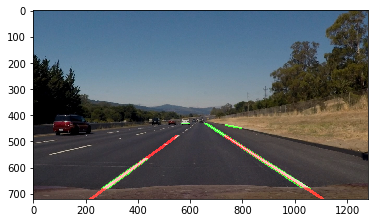

In [5]:
frame = imgproc(mpimg.imread('./test_images/straight_lines2.jpg'))
#apply distortion correction
frame.mtx = mtx
frame.dist = dist
frame.undistort()
#convert to grayscale
frame.grayscale()
# apply gaussian blur
frame.gaussian_blur(5)
# perform edge detection
frame.canny(100,200)
# cut out ROI
imshape = frame.img.shape
vertices = np.array([[(1/7*imshape[1],imshape[0]-40),(2/5*imshape[1], 3/5*imshape[0]), (3/5*imshape[1], 3/5*imshape[0]), (9/10*imshape[1],imshape[0]-40)]], dtype=np.int32)
frame.region_of_interest(vertices)
# select lines from image [hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)]
hough, m_l, b_l, m_r, b_r = frame.hough_lines(1, np.pi/180, 40, 20, 5)
# compute weighted image [weighted_img(img, initial_img, α=0.8, β=1., λ=0.)]
frame.weighted_img(hough, α=0.8, β=1., λ=0.)
# plot image
plt.figure()
plt.imshow(frame.img, cmap='gray')


In [6]:
#Compute the perspective transformation matrix M
y_min = 460
y_max = imshape[0]
src = ([(y_min-b_l)/m_l,y_min],[(y_min-b_r)/m_r,y_min],[(y_max-b_r)/m_r,y_max],[(y_max-b_l)/m_l,y_max])
src = np.float32(src)
dst = np.float32([[250,0],[1030,0],[1030,720],[250,720]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
#store transformation matrix in imgproc
frame.M = M
frame.Minv = Minv

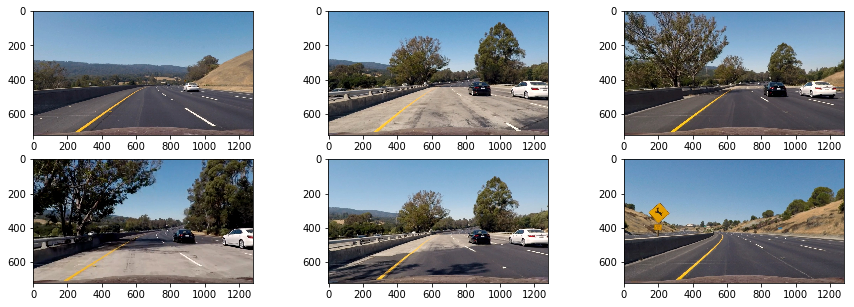

In [7]:
#load test images and perform perspective correction and image transform
images = glob.glob('./test_images/test*.jpg')
#images = glob.glob('./test_images/straight_lines*.jpg')

plt.figure(figsize=(15,5))
i=0
for img in images:
    frame.load_image(mpimg.imread(img))
    frame.undistort()
    #frame.ptransform()
    i=i+1
    plt.subplot(2,3,i)
    plt.imshow(frame.img)

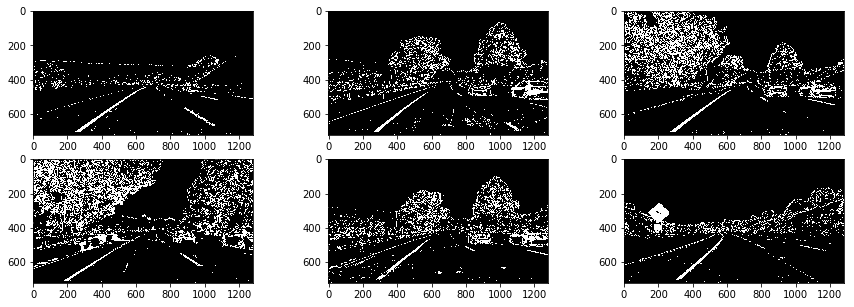

In [8]:
plt.figure(figsize=(15,5))
i=0
for img in images:
    frame.load_image(mpimg.imread(img))
    frame.undistort()
    frame.cg_thresh()
    i=i+1
    plt.subplot(2,3,i)
    plt.imshow(frame.img,cmap='gray')

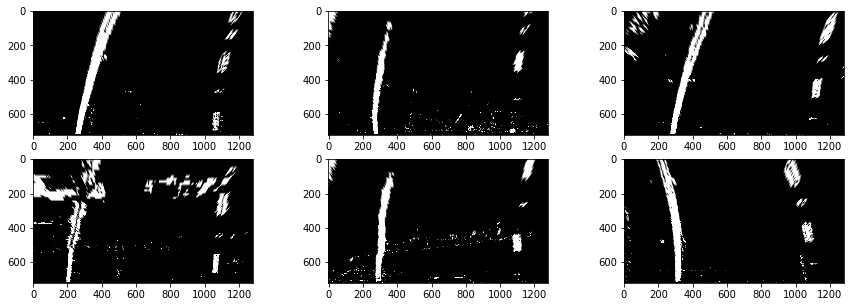

In [9]:
plt.figure(figsize=(15,5))
i=0
for img in images:
    frame.load_image(mpimg.imread(img))
    frame.undistort()
    frame.cg_thresh()
    frame.ptransform()
    i=i+1
    plt.subplot(2,3,i)
    plt.imshow(frame.img,cmap='gray')

## Lane detection

### 1. with test images

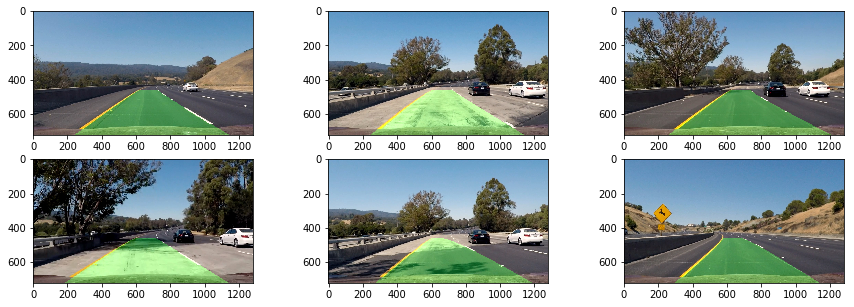

In [10]:
plt.figure(figsize=(15,5))
i=0
for img in images:
    frame=imgproc(mpimg.imread(img))
    frame.ini_tform(mtx,dist,M,Minv)
    frame.undistort()
    frame.cg_thresh()
    frame.ptransform()
    frame.find_lanes_1()
    frame.draw_lanes()
    i=i+1
    plt.subplot(2,3,i)
    plt.imshow(frame.img)

### 2. with test videos

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    frame.load_image(image)
    frame.undistort()
    frame.cg_thresh()
    frame.ptransform()
    frame.find_lanes_1()
    
    return frame.img

In [ ]:
video_output = 'test_videos_output/project_video.mp4'
video_input = VideoFileClip("project_video.mp4")
global frame
frame = imgproc([])
frame.ini_tform(mtx,dist,M,Minv)
clip = video_input.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(video_output, audio=False)

In [ ]:
video_output = 'test_videos_output/challenge_video.mp4'
video_input = VideoFileClip("challenge_video.mp4")
global frame
frame = imgproc([])
frame.ini_tform(mtx,dist,M,Minv)
clip = video_input.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(video_output, audio=False)

In [ ]:
video_output = 'test_videos_output/harder_challenge_video.mp4'
video_input = VideoFileClip("harder_challenge_video.mp4")
global frame
frame = imgproc([])
frame.ini_tform(mtx,dist,M,Minv)
clip = video_input.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(video_output, audio=False)